### Importar base de dados e instalar framework de recomendação

### Importar bibliotecas

In [33]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar (3).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [34]:
import sys
!{sys.executable} -m pip install caserecommender

In [35]:
import pandas as pd
import numpy as np

In [36]:
movies = pd.read_csv('./dataset/movies_sample.csv')
movies.tail()

,movieId,title,genres
428,129857,Bright Days Ahead (2013),Drama|Romance
429,130344,Coast of Death (2013),Children|Documentary|Drama
430,130408,A Rumor Of War (1980),(no genres listed)
431,130510,Berserk: The Golden Age Arc 3 - Descent (2013),Action|Animation|Fantasy
432,131239,Three Quarter Moon (2011),Comedy|Drama


In [37]:
ratings = pd.read_csv('./dataset/ratings_sample.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788


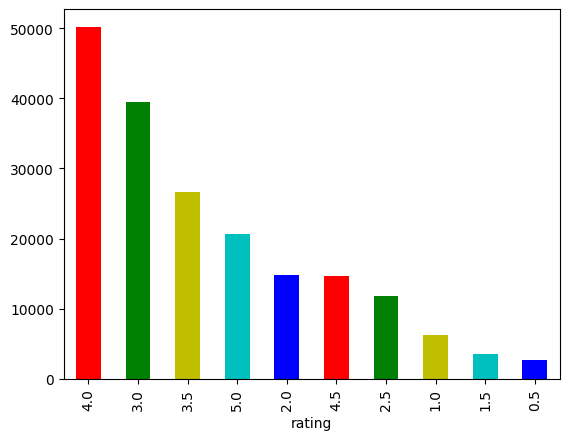

In [38]:
import matplotlib.pyplot as plt
ratings.rating.value_counts().plot(kind='bar', color=['r', 'g', 'y', 'c', 'b']);
plt.show()

In [39]:
df = ratings[['userId', 'movieId', 'rating']]
df.tail()

,userId,movieId,rating
190616,138493,288,5.0
190617,138493,1748,5.0
190618,138493,616,4.0
190619,138493,1597,4.5
190620,138493,7371,5.0


In [40]:
df = df.merge(movies[['movieId', 'title']])
df.head()

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)


### Números de usuários e número de itens

In [41]:
print(
"""
Número de usuários: {}
Número de itens: {}
Número de interações: {}
""".format(
    df.userId.nunique(),
    df.movieId.nunique(),
    df.shape[0]
)
)


Número de usuários: 11090
Número de itens: 417
Número de interações: 190621



### Mapeamento em idx

In [42]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

In [43]:
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
df.head()

,userId,movieId,rating,title
0,0,0,5.0,Enemy Mine (1985)
1,0,1,4.5,Beautiful Thing (1996)
2,0,2,4.0,"Aristocats, The (1970)"
3,0,3,2.0,American Psycho (2000)
4,0,4,5.0,Bowling for Columbine (2002)


In [44]:
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [45]:
print(len(map_title))
print(map_title[100])

417
Send Me No Flowers (1964)


In [46]:
# qtd interações dos usuários
df.groupby('userId').count()

,movieId,rating,title
userId,,,
0,13,13,13
1,14,14,14
2,15,15,15
3,15,15,15
4,11,11,11
...,...,...,...
11085,16,16,16
11086,11,11,11
11087,13,13,13


### Divisão do dataset

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.txt', index=False, header=False, sep='\t')
test.to_csv('test.txt', index=False, header=False, sep='\t')

In [48]:
! ls -l

total 200684
-rw-r--r-- 1 reckat reckat    19506 Aug  6 12:42  Aula01_Exemplos.ipynb
-rw-r--r-- 1 reckat reckat   110016 Aug  6 00:13  Aula01_Exercicios.ipynb
drwxr-xr-x 2 reckat reckat     4096 Mar 17  2022  dataset
-rw-r--r-- 1 reckat reckat 65019041 Aug  6 00:11 'ml-20m-compact.tar (1).gz'
-rw-r--r-- 1 reckat reckat 65019041 Aug  6 12:48 'ml-20m-compact.tar (2).gz'
-rw-r--r-- 1 reckat reckat 65019041 Aug  6 00:09  ml-20m-compact.tar.gz
-rw-r--r-- 1 reckat reckat   647016 Aug  6 00:12  out_mp_pred.txt
-rw-r--r-- 1 reckat reckat  2188294 Aug  6 10:06  out_mp_pred_binary.txt
-rw-r--r-- 1 reckat reckat  1491068 Aug  6 12:48  test.txt
-rw-r--r-- 1 reckat reckat  5966209 Aug  6 12:48  train.txt
drwxr-xr-x 7 reckat reckat     4096 Aug  6 00:06  venv


In [49]:
print('No. items: ' + str(train['movieId'].nunique()))
print('No. users: ' + str(train['userId'].nunique()))

No. items: 405
No. users: 11090


### Recomendadores

## Prever notas

In [50]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

In [51]:
MostPopular('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

prediction_time:: 40.505683 sec


Eval:: MAE: 0.701356 RMSE: 0.908405 


In [52]:
df_pred = pd.read_csv('out_mp_pred.txt', sep='\t', names=['userId', 'movieId', 'pred'])
df_pred.head(10)

,userId,movieId,pred
0,0,5,3.340482
1,0,0,3.462625
2,1,13,3.501614
3,1,16,3.075567
4,1,14,3.654597
5,1,19,4.070841
6,1,24,2.841837
7,1,20,3.174392
8,2,21,3.209831
9,3,33,4.192866


In [53]:
test[test.userId == 1]

,userId,movieId,rating,title
13,1,13,5.0,Sliding Doors (1998)
16,1,16,4.0,Rush Hour 2 (2001)
14,1,14,4.0,Go (1999)
21,1,19,5.0,Reservoir Dogs (1992)
26,1,24,3.0,"Deep End of the Ocean, The (1999)"
22,1,20,3.0,While You Were Sleeping (1995)


In [54]:
df_pred = df_pred.merge(test)

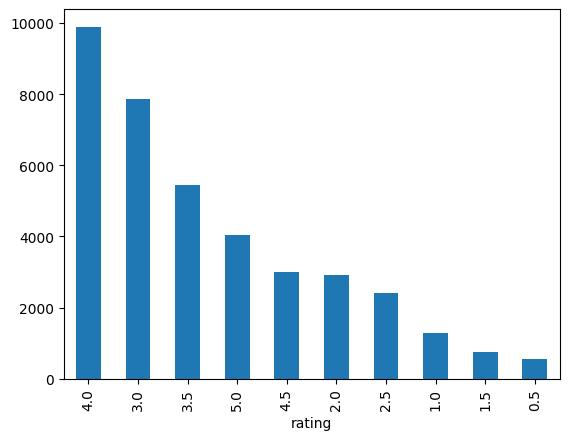

In [55]:
df_pred.rating.value_counts().plot(kind='bar')
plt.show()

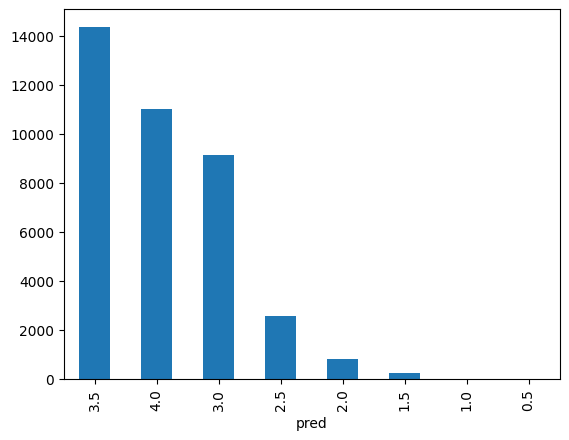

In [56]:
df_pred['pred'] = round(df_pred['pred']*2)/2
df_pred.pred.value_counts().plot(kind='bar')
plt.show()

### Top N

In [57]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular as MPR

In [58]:
MPR('train.txt', 'test.txt', 'out_mp_pred_binary.txt', as_binary=True).compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

prediction_time:: 1.420101 sec




AttributeError: `np.asfarray` was removed in the NumPy 2.0 release. Use `np.asarray` with a proper dtype instead.

In [ ]:
ranking = pd.read_csv('out_mp_pred_binary.txt', sep='\t', names=['userId', 'movieId', 'score'])
ranking['title'] = ranking.movieId.map(map_title)
ranking.head(15)

,userId,movieId,score,title
0,0,19,6379.0,Reservoir Dogs (1992)
1,0,22,4562.0,Natural Born Killers (1994)
2,0,17,4461.0,Chasing Amy (1997)
3,0,18,4279.0,Life Is Beautiful (La Vita è bella) (1997)
4,0,33,3860.0,North by Northwest (1959)
5,0,21,3666.0,Conspiracy Theory (1997)
6,0,5,3503.0,"I, Robot (2004)"
7,0,20,3471.0,While You Were Sleeping (1995)
8,0,23,3466.0,Crimson Tide (1995)
9,0,28,3344.0,My Best Friend's Wedding (1997)


### Item KNN

In [7]:
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

ItemKNN('train.txt', 'test.txt', 'rp_iknn.txt', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 3.938550 sec
prediction_time:: 0.490719 sec
Eval:: MAE: 0.663504 RMSE: 0.872175 


**Exercício 01:**

a) Encontrar o id do usuário que avaliou mais filmes na base. Informe o id externo (da base dados) e o interno (usado pelo recomendador)

In [34]:
import pandas as pd
ratings = pd.read_csv('./dataset/ratings_sample.csv')

print(ratings.groupby('userId').size().sort_values(ascending=False).head(1).index[0])

#falta retornar o userId interno

118205


b) Encontrar os 5 primeiros usuários que têm maior propensão a dar notas baixas aos filmes (use a média de ratings para isso).

In [35]:
import pandas as pd
ratings = pd.read_csv('./dataset/ratings_sample.csv')   

print(ratings.groupby('userId').mean()['rating'].sort_values().head(5).index.tolist())



[113857, 2084, 83891, 102570, 135142]


c) Encontrar os 5 filmes pior avaliados pelos usuários.

In [ ]:
import pandas as pd
ratings = pd.read_csv('./dataset/ratings_sample.csv')
movies  = pd.read_csv('./dataset/movies_sample.csv')

worst_movies_ids = ratings.groupby('movieId').mean()['rating'].sort_values().head(5).index.tolist()
# print(worst_movies_ids)
for id in worst_movies_ids:
    print(movies[movies.movieId == id].title.values[0])

[112251, 96257, 128201, 101715, 96769]
Snapshot (1979)
Heroic Purgatory (Rengoku eroica) (1970)
Hercules (2005)
Loaded (2008)
Australian Atomic Confessions (2005)


**Exercício 02:** Na aula vimos uma abordagem de recomendação não personalizada que utiliza a quantidade de interações dos itens para recomendar filmes mais populares aos usuários. Quando há feedback explícito, entretanto, a mesma abordagem "Most Popular" pode fazer uso da média das notas disponíveis, ou seja, recomendam-se os N filmes mais bem avaliados a cada usuário. Desse modo, calcule a recomendação de 5 filmes para um usuário qualquer da base considerando essa estratégia não personalizada. Utilize a base toda como conjunto de treinamento.

In [64]:
import pandas as pd
ratings = pd.read_csv('./dataset/ratings_sample.csv')
movies  = pd.read_csv('./dataset/movies_sample.csv')

best_movies_ids = ratings.groupby('movieId').mean()['rating'].sort_values(ascending=False).head(5).index.tolist()
# print(best_movies_ids)
i = 1
print("Filmes mais populares:")
for id in best_movies_ids:
    title = movies[movies.movieId == id].title.values[0]
    print(f"{i}° - {title}")
    i+=1

Filmes mais populares:
1° - Everybody Street (2013)
2° - North by Northwest (1959)
3° - Star Wars: Episode V - The Empire Strikes Back (1980)
4° - Napoléon (1927)
5° - Samouraï, Le (Godson, The) (1967)


**Exercício 03:** Com base no código disponível no notebook "Aula01_Exemplos.ipynb", implemente uma função que retorna os k filmes mais similares a um outro qualquer passado como parâmetro. 

In [20]:
from statistics import mean
from math import pow, sqrt
import pandas as pd
import numpy as np 

ratings = pd.read_csv('./dataset/ratings_sample.csv')
movies  = pd.read_csv('./dataset/movies_sample.csv')

def get_ratings(movieId):
    if movieId not in ratings['movieId'].values:
        return []
    return (ratings.loc[(ratings.movieId==movieId),'rating'].tolist())

def get_movie_mean(movieId):
    return np.mean(get_ratings(movieId))

def get_user_ids(movieId):
    if movieId not in ratings['movieId'].values:
        return []
    return (ratings.loc[(ratings.movieId==movieId),'userId'].tolist())

def get_rating(movieId, userId):
    if len(ratings[(ratings['movieId']==movieId)&(ratings['userId']==userId)]) == 0:
        return 0
    return (ratings.loc[(ratings.movieId==movieId) & (ratings.userId == userId),'rating'].iloc[0])


def similarity_score(movieId1, movieId2):
    movie_list1 = get_user_ids(movieId1)
    movie_list2 = get_user_ids(movieId2)
    common_users = list(set(movie_list1) & set(movie_list2))
    if len(common_users) == 0:
        return 0
    
    movie1_mean = get_movie_mean(movieId1)
    movie2_mean = get_movie_mean(movieId2)
    
    # Cálculo da similaridade.
    sim = []
    norm1 = []
    norm2 = []
    for user in common_users:
        rating1 = get_rating(movieId1, user)
        rating2 = get_rating(movieId2, user)
        sim.append((rating1 - movie1_mean)*(rating2 - movie2_mean))
        norm1.append(pow(rating1 - movie1_mean, 2))
        norm2.append(pow(rating2 - movie2_mean, 2))
    
    return sum(sim) / (sqrt(sum(norm1)) * sqrt(sum(norm2)))

def get_topk_similar(movieId, k):
        similarities = []

        for difMovieId in movies['movieId']:
            if difMovieId == movieId:
                continue
            
            similarities.append((difMovieId, similarity_score(movieId, difMovieId)))

        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:k]

get_topk_similar(634, 10)     

/tmp/ipykernel_1095/3532787858.py:49: RuntimeWarning: invalid value encountered in scalar divide
  return sum(sim) / (sqrt(sum(norm1)) * sqrt(sum(norm2)))


[(2618, np.float64(1.0)),
 (3933, np.float64(1.0)),
 (4761, np.float64(1.0)),
 (5229, np.float64(1.0)),
 (5290, np.float64(1.0)),
 (5560, np.float64(1.0)),
 (6111, np.float64(1.0)),
 (6351, np.float64(1.0)),
 (6489, np.float64(1.0)),
 (7029, np.float64(1.0))]